![](http://pic1.tsingdataedu.com/%E9%87%8F%E5%8C%96banner.jpg)

# 回测多因子组合策略，提升自己策略的收益表现
#### 《AI量化交易》课程案例 by @Alan 

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import sys
from collections import Counter
import multiprocessing
import copy
from sklearn.covariance import LedoitWolf
from sklearn import linear_model


In [2]:
factor_list=['factor0','factor1','factor2','factor3','factor4','factor5','factor6','factor7','factor8','factor9']


data_path = './data2/'
close_adj = pd.read_pickle(data_path+'close_adj')
is_valid = pd.read_pickle(data_path+'is_valid')

### IC计算函数

In [3]:

# 输入因子dataframe、未来n天收益率dataframe，开始日期、结束日期，返回IC序列
# 这段代码的结果已经存入IC_all，也就是这段代码是用来算因子IC值的
def get_IC(factor,re_future,startdate,enddate):
    factor = factor.convert_objects(convert_numeric=True).loc[startdate:enddate]
    IC = []
    datelist = re_future.loc[startdate:enddate].index.tolist()
    factor_arr = factor.values
    re_future_arr = re_future.loc[startdate:enddate].values
    dt_ind = []
    if factor.shape[0]==len(datelist):
        for dt in range(len(datelist)):
            x = factor_arr[dt]
            re = re_future_arr[dt]
            if np.sum(np.logical_and(~np.isnan(x),~np.isnan(re)))>200:
                dt_ind.append(dt)
                ind=np.where(np.logical_and(~np.isnan(x),~np.isnan(re)))[0]
                x = x[ind]
                re = re[ind]
                IC.append(stats.spearmanr(x, re, nan_policy='omit')[0])
    IC_pd = pd.Series(index=datelist)
    IC_pd[np.array(datelist)[dt_ind]] = IC

    return IC_pd

In [4]:
# 读取IC历史数据
IC_all = pd.read_pickle(data_path+'IC_all')

### 计算某日的因子权重

In [5]:
# IC_all列为因子，行为日期, date为当前日期，取前IC_length的IC数据,period表示IC的计算长度
# 最后返回一个最优weight
def get_weight(IC_all, factor_list,date, IC_length,period,weight_way,halflife=0):
    IC_use_all = IC_all.loc[:date,factor_list].iloc[-IC_length-period:-period]
    IC_use = copy.deepcopy(IC_use_all)

    temp = -1
    loc = []
    for f in factor_list:
        temp+=1
        # 去掉IC缺失过多的因子
        if Counter(np.isnan(IC_use[f]))[0]<IC_use.shape[0]*0.2:
            loc.append(temp)
            IC_use = IC_use.drop(f,1)

    ind_valid = np.where(~np.isnan(IC_use.sum(axis=1,skipna=False).values))[0]  # 所有因子都有ic值的行index
    IC_use = IC_use.iloc[ind_valid]
    IC_mean = IC_use.mean(axis=0).values.reshape(IC_use.shape[1],1)
    if weight_way =='ICIR_Ledoit':
        lw = LedoitWolf()
        IC_sig = lw.fit(IC_use.values).covariance_
        weight = np.dot(np.linalg.inv(IC_sig),IC_mean)
    
    elif weight_way == 'ICIR_sigma':
        IC_sig = np.cov(IC_use.values,rowvar=False)
        weight = np.dot(np.linalg.inv(IC_sig),IC_mean)
       
    elif weight_way == 'ICIR':
        IC_sig = (IC_use.std(axis=0)).values.reshape(IC_use.shape[1],1)
        weight = IC_mean/IC_sig

    elif weight_way == 'IC_halflife':
        if halflife>0:
            lam = pow(1/2,1/60)
        else:
            lam = 1
        len_IC = IC_use.shape[0]
        w = np.array([pow(lam,len_IC-1-i) for i in range(len_IC)])
        w=w/sum(w)
        weight = IC_use.mul(pd.Series(data=w,index=IC_use.index),axis=0).sum(axis=0).values

    elif weight_way == 'ICIR_halflife':
        if halflife>0:
            lam = pow(1/2,1/halflife)
        else:
            lam = 1
        len_IC = IC_use.shape[0]
        w = np.array([pow(lam,len_IC-1-i) for i in range(len_IC)])
        w=w/sum(w)
        ic_mean = IC_use.mul(pd.Series(data=w,index=IC_use.index),axis=0).sum(axis=0)
        ic_std = np.sqrt((np.power(IC_use-ic_mean,2)).mul(pd.Series(data=w,index=IC_use.index),axis=0).sum(axis=0))
        weight = ic_mean.values/ic_std.values
    
    elif weight_way == 'equal':
        weight = np.sign(IC_mean)
        
        
    w = np.array([np.nan]*len(factor_list))
    flag = 0
    for i in range(len(factor_list)):
        if i not in loc:
            w[i] = weight[flag]
            flag+=1
        else:
            w[i] = 0.0               #IC有效值过少，因子权重为0
    weight = pd.Series(w,index=factor_list)   
    

    return weight

In [6]:
# 用因子做自变量，下一期收益率做因变量，做回归，回归方式有ols、lasso正则化、岭回归（后两者用于防止过拟合）
# 回归的系数即为所需要的权重
# length为回看周期，period为因子与收益率间隔天数，interval为做回归的间隔天数
def get_weight_reg_date(Factor_dict,date,re,length,period,interval,reg_type='ols'):

    num_ = 0
    factor_list = list(Factor_dict.values())
    weight_mean = np.array([0.0]*len(factor_list))
    
    for ind in range(length,period-1,-interval):
        factor_flatten = factor_list[0].loc[:date].iloc[-ind].values.flatten()
        for i in range(1,len(factor_list)):
            factor_flatten = np.c_[factor_flatten,factor_list[i].loc[:date].iloc[-ind].values.flatten()]

        factor_flatten = pd.DataFrame(factor_flatten)
        y = re.loc[:date].iloc[-ind+period].values.flatten()
        y = pd.DataFrame(y)
        valid_x = factor_flatten.dropna(axis=0,how='any')
        valid_y = y.loc[valid_x.index]
        valid_y = valid_y.dropna(axis=0,how='any')
        valid_x = valid_x.loc[valid_y.index]
        X = valid_x.values
        Y = valid_y.values

        if X.shape[0]>3:
            num_+=1
            if reg_type=='ols':

                linearReg = linear_model.LinearRegression()
                linearReg.fit(X,Y)
                weight = linearReg.coef_[0]

            elif reg_type=='lasso':
                alphas = [0.001,0.002,0.005,0.01,0.02,0.05]
                lassoReg = linear_model.LassoCV(alphas=alphas)
                lassoReg.fit(X,Y)
                weight = lassoReg.coef_

            elif reg_type=='ridge':
                alphas = [0.01,0.02,0.05,0.1,0.2,0.5,1]
                ridgeReg = linear_model.RidgeCV(alphas=alphas)
                ridgeReg.fit(X,Y)
                weight = ridgeReg.coef_[0]
        

            weight_mean +=weight
            
    weight = pd.Series(weight_mean/num_,index=list(Factor_dict.keys()))
    return weight

### 因子合成

In [7]:
# 输入日期，输入方式，输入加权方式，输入整体factor值，得到整体处理后的factor值


def get_factor_combine_date(date,factor_combine,Factor_dict,weight,weight_way,is_valid,factor_pro='rank'):

    f_ind = -1
    factor_exist = []
    for f in Factor_dict.keys():

        f_ind+=1
        data = Factor_dict[f].loc[date]
        
        if factor_pro == 'rank':
            rank_factor = data.rank()
        else:
            rank_factor = data
        factor = data
        
        if weight_way=='ols' or weight_way=='lasso' or weight_way=='ridge':
            factor_combine+=factor.fillna(0.0)*weight[f]
            
        else:
            factor_combine+=rank_factor.fillna(rank_factor.mean())*weight[f]
            
    factor_combine[is_valid.loc[date:date]==0] = np.nan

    return factor_combine

In [8]:
# 输入日期，输入方式，输入加权方式，输入整体factor值，得到整体处理后的factor值

def get_factor_combine(startdate,enddate,Factor_path,factor_list,is_valid,close_adj,IC_all=0,weight_way='equal',factor_pro='rank',halflife=0):
    if type(startdate)==str:
        startdate = pd.Timestamp(startdate)
    
    if type(enddate)==str:
        enddate = pd.Timestamp(enddate)
    
    re = close_adj.pct_change(5).loc['20130104':enddate]
    Factor_dict = {}
    for f in factor_list:
        Factor_dict[f] = (pd.read_pickle(Factor_path+f)).loc['20130104':enddate]
    columns_ = is_valid.columns
    index_ = is_valid.loc[startdate:enddate].index
    factor_combine = pd.DataFrame(0., index=index_, columns=columns_)

    pool = multiprocessing.Pool(processes=10)
    result = []

    interval = 10    #每隔interval天重新计算weight
    i = 0
    for dt in index_:
        if i%interval == 0:
            if weight_way=='ICIR_sigma' or weight_way=='ICIR_Ledoit' or weight_way=='ICIR' \
            or weight_way=='IC_halflife' or weight_way=='ICIR_halflife' or weight_way=='equal':
                weight = get_weight(IC_all,factor_list,dt,120,5,weight_way,halflife)
            elif weight_way=='ols' or weight_way=='lasso' or weight_way=='ridge':
                weight = get_weight_reg_date(Factor_dict,dt,re,120,5,10,weight_way)
        factor_combine_k = pd.DataFrame(0.,index=[dt],columns=columns_)
        result.append(pool.apply_async(get_factor_combine_date,args=(dt,factor_combine_k,Factor_dict,weight,weight_way,is_valid,factor_pro)))
        
    for i,d in enumerate(result):
        res = d.get()
        print(res.index[0])
        factor_combine.loc[res.index]=res

    pool.close()
    pool.join()
        

    return factor_combine

In [9]:
startdate = '20140102'
enddate = '20141231'

# 等权
# act_equal = get_factor_combine(startdate,enddate,data_path,factor_list,is_valid,close_adj,IC_all,weight_way='equal',factor_pro='rank',halflife=0)

# IC加权
# act_ic = get_factor_combine(startdate,enddate,data_path,factor_list,is_valid,close_adj,IC_all,weight_way='IC_halflife',factor_pro='rank',halflife=0)

# ICIR加权
# act_icir = get_factor_combine(startdate,enddate,data_path,factor_list,is_valid,close_adj,IC_all,weight_way='ICIR',factor_pro='rank',halflife=0)

# 最优复合ICIR加权
# act_icir_sigma = get_factor_combine(startdate,enddate,data_path,factor_list,is_valid,close_adj,IC_all,weight_way='ICIR_sigma',factor_pro='rank',halflife=0)

# 最优复合ICIR加权（Ledoit调整）
# act_icir_Ledoit = get_factor_combine(startdate,enddate,data_path,factor_list,is_valid,close_adj,IC_all,weight_way='ICIR_Ledoit',factor_pro='rank',halflife=0)

# ols回归加权
act_ols = get_factor_combine(startdate,enddate,data_path,factor_list,is_valid,close_adj,IC_all,weight_way='ols',factor_pro='rank',halflife=0)

2014-01-02 00:00:00
2014-01-03 00:00:00
2014-01-06 00:00:00
2014-01-07 00:00:00
2014-01-08 00:00:00
2014-01-09 00:00:00
2014-01-10 00:00:00
2014-01-13 00:00:00
2014-01-14 00:00:00
2014-01-15 00:00:00
2014-01-16 00:00:00
2014-01-17 00:00:00
2014-01-20 00:00:00
2014-01-21 00:00:00
2014-01-22 00:00:00
2014-01-23 00:00:00
2014-01-24 00:00:00
2014-01-27 00:00:00
2014-01-28 00:00:00
2014-01-29 00:00:00
2014-01-30 00:00:00
2014-02-07 00:00:00
2014-02-10 00:00:00
2014-02-11 00:00:00
2014-02-12 00:00:00
2014-02-13 00:00:00
2014-02-14 00:00:00
2014-02-17 00:00:00
2014-02-18 00:00:00
2014-02-19 00:00:00
2014-02-20 00:00:00
2014-02-21 00:00:00
2014-02-24 00:00:00
2014-02-25 00:00:00
2014-02-26 00:00:00
2014-02-27 00:00:00
2014-02-28 00:00:00
2014-03-03 00:00:00
2014-03-04 00:00:00
2014-03-05 00:00:00
2014-03-06 00:00:00
2014-03-07 00:00:00
2014-03-10 00:00:00
2014-03-11 00:00:00
2014-03-12 00:00:00
2014-03-13 00:00:00
2014-03-14 00:00:00
2014-03-17 00:00:00
2014-03-18 00:00:00
2014-03-19 00:00:00


In [10]:
zz500_close=pd.read_pickle("./data2/500_close")
stock_close=pd.read_pickle("./data2/stock_close")

## 此处需要修改成对应的结果

real_predict=act_ols

<Figure size 432x288 with 0 Axes>

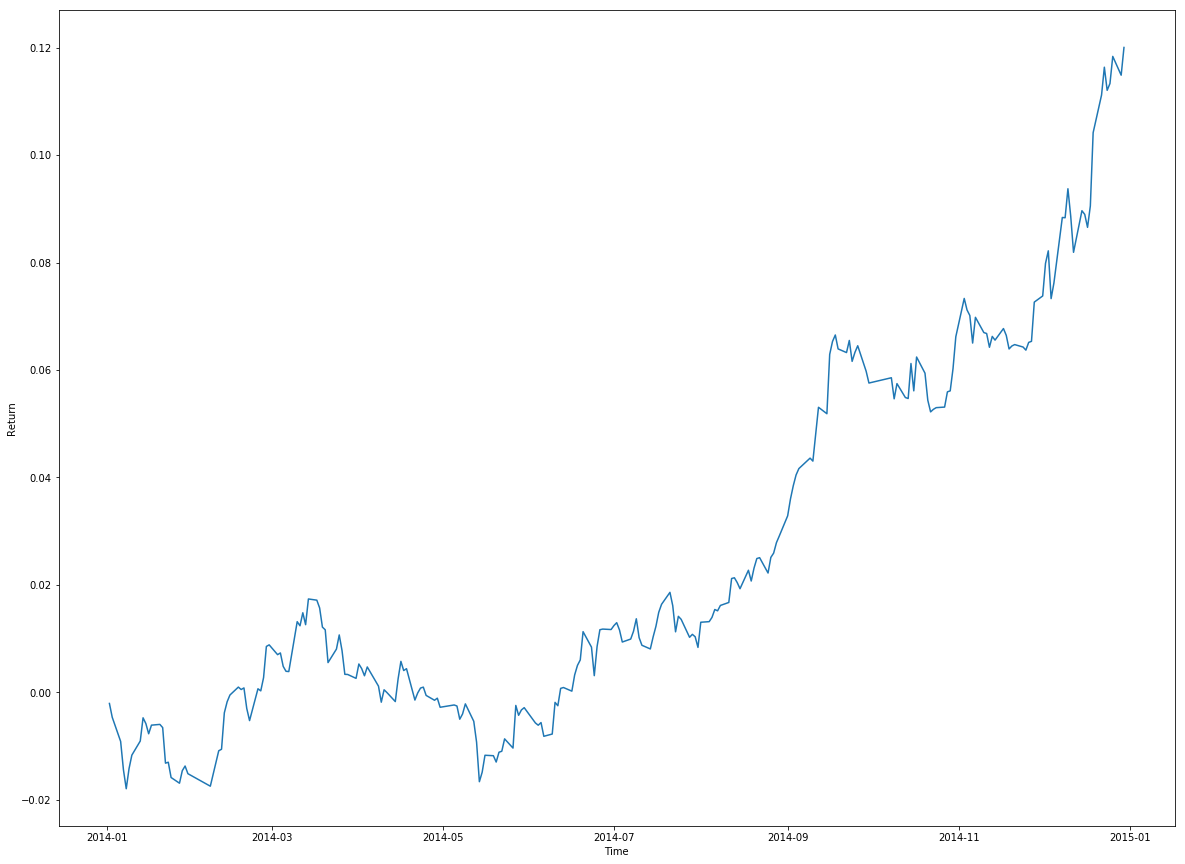

In [11]:
## 通过因子值进行对应的回测。
## 选股和回测逻辑为：根据因子值的大小排序，直接选出排名前100的股票，
## 利用这100只股票的平均收益率作为组合当日的收益率，减去zz500当日的收益率为组合的超额收益率
## 超额收益率的累加即为整体的收益率（实际应当累乘，这里因为收益时间短，差别不大）

all_dates=list(stock_close.index)
all_stocks=list(stock_close.columns)
stock_growth=stock_close.pct_change(1).shift(-1)
zz500_growth=zz500_close.pct_change(1).shift(-1)

date_returns=[]
for date in all_dates[:-1]:
    sort_stocks=[]
    for stock in all_stocks:
        if not math.isnan(real_predict.loc[date,stock]) and not math.isnan(stock_growth.loc[date,stock]):
            sort_stocks.append((real_predict.loc[date,stock],stock_growth.loc[date,stock]))
    sort_stocks.sort()
    sort_stocks.reverse()
    return_add=0.
    for i in range(100):
        return_add+=sort_stocks[i][1]
    date_returns.append(return_add/100.-zz500_growth.loc[date][0])
add_date_returns=[]
for i in range(len(date_returns)):
    add_date_returns.append(sum(date_returns[0:i+1]))
plt.figure(1)
plt.figure(figsize=(20,15))
index = all_dates[:-1]
values = add_date_returns
plt.ylabel("Return")
plt.xlabel("Time")
plt.plot(index,values)

plt.show()

### 版权归 © 稀牛学院 所有 保留所有权利
![](http://pic1.tsingdataedu.com/%E7%A8%80%E7%89%9B%20x%20%E7%BD%91%E6%98%93.png)